In [57]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from tabulate import tabulate

In [58]:
client_cost_per_piece = 0.5
internal_cost_per_piece = 0.7
salvage_rate = 0.1

machine = {
    'A': {
        'purchase_cost': 18000,
        'annual_maintenance_cost': 1350,
        'setup_cost': 750,
        'production_rate': 6,
        'internal_rate': 6*2
    },
    'B': {
        'purchase_cost': 27000,
        'annual_maintenance_cost': 2430,
        'setup_cost': 1000,
        'production_rate': 12,
        'internal_rate': int(12*1.5),
    },
    'C': {
        'purchase_cost': 64000,
        'annual_maintenance_cost': 4250,
        'setup_cost': 3000,
        'production_rate': 30,
        'internal_rate': 30,
    },
    'D': {
        'purchase_cost': 124000,
        'annual_maintenance_cost': 14400,
        'setup_cost': 6000,
        'production_rate': 30,
        'internal_rate': 30,
    },
}

Assumptions:<br>
- 200k pieces/year<br>
<br>because the machines have a 1M piece life cycle and the managers want a 5 year life cycle each year we need to produce 200K pieces for a total of 1M pieces after 5 years.
<br><br>

- salvage price of 10% of initial price<br>
<br>We analysed prices from [this website](https://www.sterlingmachinery.com/new-used-lathes-sale-engine-lathe/new-used-engine-lathe.html) and determined that the average resale price is close 0.1 times the original prices for those machines.
<br><br>

- The machines will run 2 shifts (8 hours each)<br>
<br>The reason for that is that we feel like it is useless to only utilize a 1/3 of a day to produce parts as it is a waste of time and can seriously slow down the project. It is also just common industry practice to have the machines run for more than 1 shift/day.
<br><br>

- 11% interest rate<br>
<br> we use that rate simply because it is very similar to the rates seen in practice problems throughout the course.
<br><br>

- Interest is compunded yearly (for simplicity's sake)

- 52 weeks x 5 days/week = 260 business days per year

In [59]:
base_hourly_salary = 14.29
extra_shift_multiplier = 0.25
benefits_multiplier = 0.63      # is applied to base pay only
manufacturing_overhead = 0.47   # is applied to direct pay

def dollar(amount): return "${:,.2f}".format(amount)


def nominal_labour_cost(days=260, shifts=2):
    '''for 1 operator'''

    hourly_cost1 = (
        base_hourly_salary + 
        base_hourly_salary * benefits_multiplier + 
        base_hourly_salary * manufacturing_overhead
    )
    shift1 = days * 8 * hourly_cost1
    
    # print(f'hourly cost shift 1 = {round(hourly_cost1,2)}')

    if shifts > 1:

        extra_shifts = shifts-1
        direct_pay = base_hourly_salary * (1 + extra_shift_multiplier)
        hourly_costx = (
            direct_pay + 
            base_hourly_salary * benefits_multiplier +
            direct_pay * manufacturing_overhead
        )
        shiftx = days * 8 * extra_shifts * hourly_costx
    else:
        shiftx = 0
    
    # print(f'hourly cost for extra shifts = {round(hourly_costx,2)}')

    total_labour_cost = shift1 + shiftx

    return round(total_labour_cost,2)

In [60]:
def number_of_machines_required(machine_type, num_shifts=2, client_target=200000, internal_target=8000):
    '''
    This function tells you how many machines you need given a type and the number
    of shifts that the machines will be running (1, 2, or 3). It is assumed that machines run
    5 days/week, 4 weeks/month, 12 months/year.
    52 weeks x 5 days/week = 260 business days/year
    '''
    
    r1 = machine[machine_type]['production_rate']
    r2 = machine[machine_type]['internal_rate']
    c1 = client_target
    c2 = internal_target
    s = num_shifts      # number of shifts per day
    d1 = 0              # days spent producing for client
    d2 = 0              # days spent producing internally

    # N*r1*(8)*s*d1 = c1
    # N*r2*(8)*s*(260-d1) = c2
    # N

    N = (c2+c1*(r2/r1))/(260*8*s*r2)
    N = math.ceil(N)
    d1 = math.ceil(c1/(N*r1*s*8))
    d2 = math.ceil(c2/(N*r2*s*8))

    return N, d1, d2

num_machines, d1, d2 = number_of_machines_required(machine_type='B', num_shifts=2, client_target=200000, internal_target=8000)

print(f'The number of machines required: {num_machines}')
print(f'Days spent producing client pieces:   {d1}')
print(f'Days spent producing internal pieces: {d2}')
print(f'                          Total days: {d1+d2}')

The number of machines required: 5
Days spent producing client pieces:   209
Days spent producing internal pieces: 6
                          Total days: 215


In [61]:
def cashflow_analysis(machine_type, num_shifts=2, client_target=200000, internal_target=8000):
    num_machines, d1, d2 = number_of_machines_required(machine_type,
                                                        num_shifts,
                                                        client_target,
                                                        internal_target
                                                        )
    num_days = d1 + d2
    if machine_type == 'A' or machine_type == 'B':
        operators_required = num_machines
    elif machine_type == 'C':
        operators_required = num_machines//2
    else:
        operators_required = 0

    labour_cost = operators_required * nominal_labour_cost(num_days, num_shifts)

    cash_flow = {
        'negative':{
            '1time': [
                num_machines * machine[machine_type]['purchase_cost'], 
            ],
            'annual': [
                labour_cost, 
                num_machines * machine[machine_type]['annual_maintenance_cost'],
                client_cost_per_piece * client_target,
                internal_cost_per_piece * internal_target,
                num_machines * machine[machine_type]['setup_cost'], # setup cost for client
                num_machines * machine[machine_type]['setup_cost'], # setup cost for internal
            ]
        },
        'positive':{
            '1time': [salvage_rate * machine[machine_type]['purchase_cost'] * num_machines],
            'annual': [8000*4.26] # savings when producing 8000 pieces internally
        }
    }
    
    return cash_flow

In [62]:
'''I want to plot machine A for 200k pieces'''
for m in ['A', 'B', 'C', 'D']:
    print(cashflow_analysis(m))

{'negative': {'1time': [162000], 'annual': [1113759.99, 12150, 100000.0, 5600.0, 6750, 6750]}, 'positive': {'1time': [16200.0], 'annual': [34080.0]}}
{'negative': {'1time': [135000], 'annual': [561318.35, 12150, 100000.0, 5600.0, 5000, 5000]}, 'positive': {'1time': [13500.0], 'annual': [34080.0]}}
{'negative': {'1time': [128000], 'annual': [113830.14, 8500, 100000.0, 5600.0, 6000, 6000]}, 'positive': {'1time': [12800.0], 'annual': [34080.0]}}
{'negative': {'1time': [248000], 'annual': [0.0, 28800, 100000.0, 5600.0, 12000, 12000]}, 'positive': {'1time': [24800.0], 'annual': [34080.0]}}


In [63]:
day_table = {
    'Machine Type': ['A', 'B', 'C', 'D'],
    'Machines Required': [],
    'Days Producing for Client': [],
    'Days Producing Internally': [],
    'Total Production Days': [],
}
cashflow_table = {
    'Machine Type': ['A', 'B', 'C', 'D'],
    '- Purchase Cost': [],
    '- Annual Labour Cost': [],
    '- Annual Maintenance Cost': [],
    '- Annual Client Piece Cost': [],
    '- Annual Internal Piece Cost': [],
    '- Annual Setup Cost': [],
    '+ Salvage Value': [],
    '+ Annual Internal Savings': [],
}
summary_table = {
    'Machine Type': ['A', 'B', 'C', 'D'],
    'One-time Outflow': [],
    'Annual Outflow': [],
    'Annual Inflow': [],
    'One-time Inflow': [],
}

for mtype in ['A', 'B', 'C', 'D']:
    num_machines, d1, d2 = number_of_machines_required(mtype)
    
    day_table['Machines Required'].append(num_machines)
    day_table['Days Producing for Client'].append(d1)
    day_table['Days Producing Internally'].append(d2)
    day_table['Total Production Days'].append(d1+d2)
    
    cashflow = cashflow_analysis(mtype)

    cashflow_table['- Purchase Cost'].append(cashflow['negative']['1time'][0])
    cashflow_table['- Annual Labour Cost'].append(cashflow['negative']['annual'][0])
    cashflow_table['- Annual Maintenance Cost'].append(cashflow['negative']['annual'][1])
    cashflow_table['- Annual Client Piece Cost'].append(cashflow['negative']['annual'][2])
    cashflow_table['- Annual Internal Piece Cost'].append(cashflow['negative']['annual'][3])
    cashflow_table['- Annual Setup Cost'].append(cashflow['negative']['annual'][4] + cashflow['negative']['annual'][5])
    cashflow_table['+ Salvage Value'].append(cashflow['positive']['1time'][0])
    cashflow_table['+ Annual Internal Savings'].append(cashflow['positive']['annual'][0])

    summary_table['One-time Outflow'].append(sum(cashflow['negative']['1time']))
    summary_table['Annual Outflow'].append(sum(cashflow['negative']['annual']))
    summary_table['Annual Inflow'].append(sum(cashflow['positive']['annual']))
    summary_table['One-time Inflow'].append(sum(cashflow['positive']['1time']))

In [64]:
day_df = pd.DataFrame(day_table)
cashflow_df = pd.DataFrame(cashflow_table)
summary_df = pd.DataFrame(summary_table)

In [65]:
def display(df):
    print(tabulate(df.T, tablefmt='fancy_grid'))

In [66]:
display(day_df)

╒═══════════════════════════╤═════╤═════╤═════╤═════╕
│ Machine Type              │ A   │ B   │ C   │ D   │
├───────────────────────────┼─────┼─────┼─────┼─────┤
│ Machines Required         │ 9   │ 5   │ 2   │ 2   │
├───────────────────────────┼─────┼─────┼─────┼─────┤
│ Days Producing for Client │ 232 │ 209 │ 209 │ 209 │
├───────────────────────────┼─────┼─────┼─────┼─────┤
│ Days Producing Internally │ 5   │ 6   │ 9   │ 9   │
├───────────────────────────┼─────┼─────┼─────┼─────┤
│ Total Production Days     │ 237 │ 215 │ 218 │ 218 │
╘═══════════════════════════╧═════╧═════╧═════╧═════╛


In [67]:
display(cashflow_df)

╒══════════════════════════════╤════════════╤═══════════╤═══════════╤══════════╕
│ Machine Type                 │ A          │ B         │ C         │ D        │
├──────────────────────────────┼────────────┼───────────┼───────────┼──────────┤
│ - Purchase Cost              │ 162000     │ 135000    │ 128000    │ 248000   │
├──────────────────────────────┼────────────┼───────────┼───────────┼──────────┤
│ - Annual Labour Cost         │ 1113759.99 │ 561318.35 │ 113830.14 │ 0.0      │
├──────────────────────────────┼────────────┼───────────┼───────────┼──────────┤
│ - Annual Maintenance Cost    │ 12150      │ 12150     │ 8500      │ 28800    │
├──────────────────────────────┼────────────┼───────────┼───────────┼──────────┤
│ - Annual Client Piece Cost   │ 100000.0   │ 100000.0  │ 100000.0  │ 100000.0 │
├──────────────────────────────┼────────────┼───────────┼───────────┼──────────┤
│ - Annual Internal Piece Cost │ 5600.0     │ 5600.0    │ 5600.0    │ 5600.0   │
├───────────────────────────

In [68]:
display(summary_df)

╒══════════════════╤════════════╤═══════════╤═══════════╤══════════╕
│ Machine Type     │ A          │ B         │ C         │ D        │
├──────────────────┼────────────┼───────────┼───────────┼──────────┤
│ One-time Outflow │ 162000     │ 135000    │ 128000    │ 248000   │
├──────────────────┼────────────┼───────────┼───────────┼──────────┤
│ Annual Outflow   │ 1245009.99 │ 689068.35 │ 239930.14 │ 158400.0 │
├──────────────────┼────────────┼───────────┼───────────┼──────────┤
│ Annual Inflow    │ 34080.0    │ 34080.0   │ 34080.0   │ 34080.0  │
├──────────────────┼────────────┼───────────┼───────────┼──────────┤
│ One-time Inflow  │ 16200.0    │ 13500.0   │ 12800.0   │ 24800.0  │
╘══════════════════╧════════════╧═══════════╧═══════════╧══════════╛


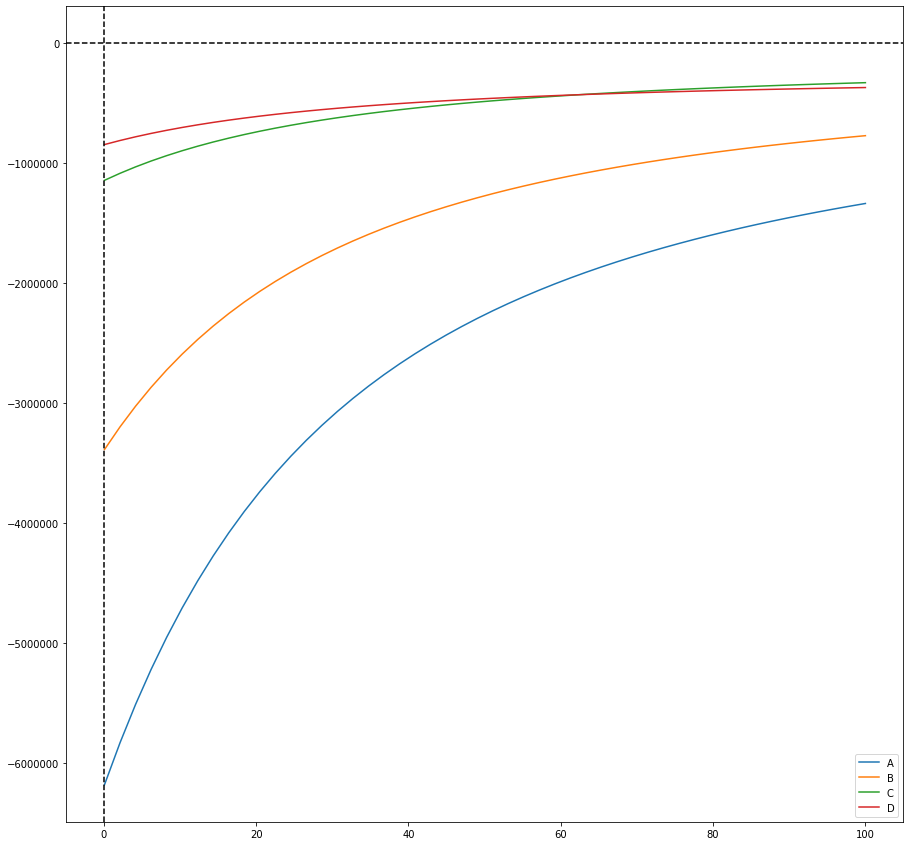

In [69]:
def FP(i, N):
    return (1+i)**N


def PF(i, N):
    return 1/FP(i, N)


def AP(i, N):
    return (i*(1+i)**N)/((1+i)**N - 1)


def PA(i, N, g=None):
    if g is not None:
        return PA(i, N)/(1+g)

    return 1/AP(i, N)


def PW(cashflow, i, revenue=0):
    pw = (
        - sum(cashflow['negative']['1time']) +
        (sum(cashflow['positive']['annual']) - sum(cashflow['negative']['annual']) + revenue) * PA(i, N=5) +
        sum(cashflow['positive']['1time'])* PF(i,N=5)
    )
    return pw

def add_origin():
    plt.axhline(color='black', linestyle='--')
    plt.axvline(color='black', linestyle='--')

def plot_pw():
    for mtype in ['A', 'B', 'C', 'D']:
        cashflow = cashflow_analysis(mtype)
        domain = np.linspace(0.1, 100)
        image = np.array([PW(cashflow, i/100) for i in domain])
        plt.plot(domain, image)
    plt.legend(['A', 'B', 'C', 'D'])
    add_origin()

plt.figure(figsize=(15,15))
plot_pw()

In [70]:
MARR = 0.15
revenue = 2e5*4.26  # we can assume that the 200,000 pieces are sold to our client at a similiar price of $4.26 that we bought our internal part

pw_table = {
    'Machine Type': ['A', 'B', 'C', 'D'],
    f'Present Worth at MARR={MARR*100}%': [],
    f'Assuming an Annual Revenue of ${revenue}': [],
}

for mtype in ['A', 'B', 'C', 'D']:
    cashflow = cashflow_analysis(mtype)
    pw_table[f'Present Worth at MARR={MARR*100}%'].append(round(PW(cashflow, i=MARR),2))
    pw_table[f'Assuming an Annual Revenue of ${revenue}'].append(round(PW(cashflow,i=MARR, revenue=revenue),2))
    
pw_df = pd.DataFrame(pw_table)
display(pw_df)

╒═════════════════════════════════════════╤═════════════╤═════════════╤════════════╤════════════╕
│ Machine Type                            │ A           │ B           │ C          │ D          │
├─────────────────────────────────────────┼─────────────┼─────────────┼────────────┼────────────┤
│ Present Worth at MARR=15.0%             │ -4213170.88 │ -2323910.65 │ -811677.73 │ -652409.94 │
├─────────────────────────────────────────┼─────────────┼─────────────┼────────────┼────────────┤
│ Assuming an Annual Revenue of $852000.0 │ -1357134.73 │ 532125.49   │ 2044358.41 │ 2203626.2  │
╘═════════════════════════════════════════╧═════════════╧═════════════╧════════════╧════════════╛
